In [105]:
import pandas as pd 
import numpy as np
from bertopic import BERTopic

In [106]:
#load data  
df = pd.read_csv('arizona_clean.csv')

In [128]:
from nltk.tokenize import word_tokenize
import string
from stop_words import get_stop_words

stop_words = get_stop_words('en')

In [129]:
#Append sentences from newsgroup documents to raw sentences
raw_sentences = []
for s in df.tweet:
  raw_sentences.append( s )

In [130]:
import re


def only_letters(tested_string):
    for letter in tested_string:
        if letter not in "abcdefghijklmnopqrstuvwxyz":
            return False
    return True

#I just did an adhoc cleaning, as I see documents
#have some non English characters, so I use above method only_letters
#to filter instead of default isalpha python method
def clean_data(s): 
    s = s.replace(">","").lower()
    if "lines:" in s :
        index = s.index("lines:")
        s = s[index+10:] 
        
    word_list = word_tokenize(s)
    cleaned = []
    for w in word_list:
        if w not in stop_words:
            if w in string.punctuation or only_letters(w):
                if w in string.punctuation or len( set(w) ) > 1:
                    cleaned.append( w)
    return " ".join(cleaned) ,cleaned           
            

#from documents clean sentence and return vocublary of sentence
def build_data(docs):

    n_docs = len(docs)
    sentences = []  # sentences
    token_lists = []  # words vocublary
    
    for i in range(len(docs)):
        sentence,token_list = clean_data(docs[i])
        if token_list: #if not all items eleminated
            sentences.append(sentence)
            token_lists.append(token_list)
        
    return sentences, token_lists

In [131]:
print("Number of raw sentences ", len(raw_sentences))

Number of raw sentences  3773


In [132]:
sentences, token_lists = build_data(raw_sentences )

In [1]:
from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('bert-base-nli-max-tokens')

In [2]:
model_bert

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': True, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [134]:
embedding_bert = np.array(model_bert.encode(sentences, show_progress_bar=True))

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

In [145]:
print("Bert Embedding shape", embedding_bert.shape)
print("Bert Embedding sample", embedding_bert[0][0:50])

Bert Embedding shape (3773, 768)
Bert Embedding sample [ 0.89537156  0.94339484  0.87277555  0.5936075   1.2208126   0.5396096
  0.66238016  0.3774641   1.0256324  -0.01991004  0.22633192  0.92647785
  1.3440703   0.5543324   0.25722656  0.21688896  0.8235722  -0.30126578
  1.4533395   0.24997318  0.48294252 -0.23555848  0.45381832  0.36171246
  0.6796519   0.29896826  0.5313382   0.85382557  0.08245678  0.2919493
  0.18393776  0.5772768   0.11661665  0.7144707   0.13168904  0.968011
  0.19390449  0.4026481   0.25395086  0.06831026  0.39011222  0.4626635
  0.40173835 -0.18367738 -0.6762942   0.5156922   0.07588437  0.24038555
  0.02673372  0.21360251]


In [213]:
from sklearn.cluster import KMeans
from collections import Counter
num_topics = 10
def predict_topics_with_kmeans(embeddings,num_topics):
  kmeans_model = KMeans(num_topics)
  kmeans_model.fit(embeddings)
  topics_labels = kmeans_model.predict(embeddings)
  return topics_labels

In [214]:
#Apply Kmeans without dimension reduction
labels_bert_raw  = predict_topics_with_kmeans(embedding_bert,num_topics)

In [215]:
def reduce_umap(embedding):
  reducer = umap.UMAP() #umap.UMAP()
  embedding_umap = reducer.fit_transform( embedding  )
  return embedding_umap

def plot_embeddings(embedding, labels,title):

    labels = np.array( labels )
    distinct_labels =  set( labels )
    
    n = len(embedding)
    counter = Counter(labels)
    for i in range(len( distinct_labels )):
        ratio = (counter[i] / n )* 100
        cluster_label = f"cluster {i}: { round(ratio,2)}"
        x = embedding[:, 0][labels == i]
        y = embedding[:, 1][labels == i]
        plt.plot(x, y, '.', alpha=0.4, label= cluster_label)
    plt.legend(title="Topic",loc = 'upper left', bbox_to_anchor=(1.01,1))
    plt.title(title)

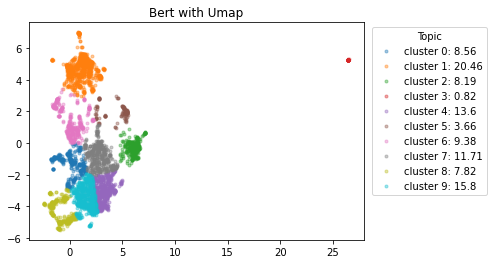

In [216]:
#Apply Kmeans for Bert Vectors  with Umap  dimension reduction

embedding_umap_bert = reduce_umap( embedding_bert )
labels_bert_umap  = predict_topics_with_kmeans(embedding_umap_bert,num_topics)
plot_embeddings(embedding_umap_bert, labels_bert_umap,"Bert with Umap")

In [217]:
def reduce_pca(embedding):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform( embedding )
    print( "pca explained_variance_ ",pca.explained_variance_)
    print( "pca explained_variance_ratio_ ",pca.explained_variance_ratio_)
    
    return reduced

pca explained_variance_  [11.604251  7.903386]
pca explained_variance_ratio_  [0.10702021 0.07288898]


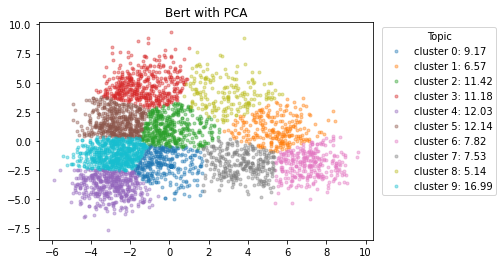

In [218]:
from sklearn.decomposition import PCA
#Apply Kmeans for Bert Vectors  with PCA  dimension reduction

embedding_bert_pca =  reduce_pca( embedding_bert )
labels_bert_pca  = predict_topics_with_kmeans(embedding_bert_pca,num_topics)

plot_embeddings(embedding_bert_pca,labels_bert_pca,"Bert with PCA")

In [219]:
def reduce_tsne(embedding):
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform( embedding )
    
    return reduced

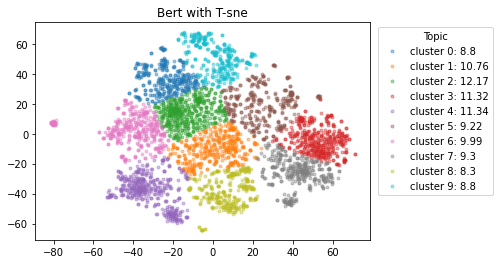

In [220]:
#Apply Kmeans for Bert Vectors  with T-sne  dimension reduction
from sklearn.manifold import TSNE

embedding_bert_tsne =  reduce_tsne( embedding_bert )
labels_bert_tsne  = predict_topics_with_kmeans(embedding_bert_tsne,num_topics)
plot_embeddings(embedding_bert_tsne,labels_bert_tsne,"Bert with T-sne")

In [221]:
from sklearn.metrics import silhouette_score
print("Silhouette score:" )

print("Raw Bert" ,silhouette_score(embedding_bert, labels_bert_raw) )

print("Bert with PCA" ,  silhouette_score(embedding_bert_pca, labels_bert_pca) )

print("Bert with Tsne" , silhouette_score(embedding_bert_tsne, labels_bert_tsne) )


print("Bert with Umap" ,  silhouette_score(embedding_umap_bert , labels_bert_umap ) )

Silhouette score:
Raw Bert 0.07684163
Bert with PCA 0.3578934
Bert with Tsne 0.38206035
Bert with Umap 0.45336258


In [193]:
df['Cluster'] = labels_bert_umap
df.shape

(3773, 3)

In [194]:
for i in range(df['Cluster'].nunique()):
    print(df[df['Cluster']==i].shape)`

(461, 3)
(781, 3)
(31, 3)
(378, 3)
(353, 3)
(313, 3)
(284, 3)
(415, 3)
(99, 3)
(658, 3)


In [222]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

data = df['tweet']
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [223]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, labels_bert_umap, 100)

In [224]:
dfs[0]['features']

0       phoenix
1      coronado
2         drink
3         photo
4     quarantin
        ...    
95        peopl
96         wait
97          lil
98       window
99         need
Name: features, Length: 100, dtype: object

In [228]:
df_cluster = pd.DataFrame(columns=['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Cluster5', 'Cluster6', 'Cluster7', 'Cluster8',
                                   'Cluster9', 'Cluster10'])
for i in range(len(dfs)):
    df_cluster[df_cluster.columns[i]] = dfs[i]['features']

In [229]:
df_cluster

,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9,Cluster10
0,phoenix,arizona,coronavirus,kino,covid,arizona,easter,week,job,quarantin
1,coronado,phoenix,covid,complex,pandem,coronavirus,quarantin,covid,work,covid
2,drink,tucson,virus,sport,quarantin,just,friday,quarantin,home,social
3,photo,quarantin,thank,site,mask,post,saturday,year,pharmaci,distanc
4,quarantin,covid,corona,tcobctaizexm,social,tucson,covid,day,az,socialdistanc
...,...,...,...,...,...,...,...,...,...,...
95,peopl,birthday,weur,loludeudduddudeudeuddfbuddudeeuddud,minut,az,grill,late,lane,kind
96,wait,yuall,spring,loluddudcudduddaudcudffenerdlif,vaccin,mad,scottsdal,let,healthycar,udcudf
97,lil,year,post,lololol,uddudc,vista,continu,test,chandler,park
98,window,traffic,staff,lolnncovidvacccin,posit,itus,shop,alway,sale,pleas


In [230]:
df_cluster.to_csv('df_cluster_bert.csv')